In [1]:
# Custom Imports
import sys
sys.path.append("..")
import GradCertModule
import XAIArchitectures
# Deep Learning Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
import pytorch_lightning as pl
# Standard Lib Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#dataset = "pathmnist"
dataset = "bloodmnist"
#dataset = "retinamnist"
#dataset = "dermamnist"

#dataset = "pneumoniamnist"
#dataset = "tissuemnist"

data = np.load('Datasets/%s.npz'%(dataset))


y_train = np.squeeze(data['train_labels'])
y_val = np.squeeze(data['val_labels'])
y_test = np.squeeze(data['test_labels'])


if(dataset in ["pathmnist", "bloodmnist", "retinamnist", "dermamnist"]):
    X_train = np.swapaxes(data['train_images'], 3, 1)/255.0
    X_val = np.swapaxes(data['val_images'], 3, 1)/255.0
    X_test = np.swapaxes(data['test_images'], 3, 1)/255.0
    
elif(dataset in ["tissuemnist", "pneumoniamnist"]):
    X_train = data['train_images']/255.0
    X_train = X_train[0:20000]
    y_train = y_train[0:20000]
    X_train = X_train[:,None]
    X_val = data['val_images']/255.0
    X_val = X_val[0:2000]
    y_val = y_val[0:2000]
    X_val = X_val[:,None]
    X_test = data['test_images']/255.0
    X_test = X_test[:,None]
    
#y_train = torch.nn.functional.one_hot(torch.Tensor(data['train_labels']).to(torch.int64), 10)
#y_val = torch.nn.functional.one_hot(torch.Tensor(data['val_labels']).to(torch.int64), 10)
#y_test = torch.nn.functional.one_hot(torch.Tensor(data['test_labels']).to(torch.int64), 10)

print("train: ", X_train.shape)
print("test: ", X_test.shape)

class custDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).float()
        self.y = y
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return self.X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    

CustTrain = custDataset(X_train, y_train)  
CustVal = custDataset(X_val, y_val) 
CustTest = custDataset(X_test, y_test)

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, train, val, test, batch_size=100):
        super().__init__()
        self.train_data = train
        self.val_data = val
        self.test_data = test
        self.batch_size = batch_size
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size)
    
dm = CustomDataModule(CustTrain, CustVal, CustTest)

train:  (11959, 3, 28, 28)
test:  (3421, 3, 28, 28)


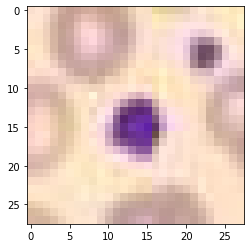

(3, 28, 28)


In [2]:
import matplotlib
import matplotlib.pyplot as plt
try:
    plt.imshow(np.swapaxes(X_train, 3, 1)[0],  cmap='gray')
    plt.show()
except:
    plt.imshow(X_train[3], cmap='gray')
    plt.show()
    
print(X_train[0].shape)

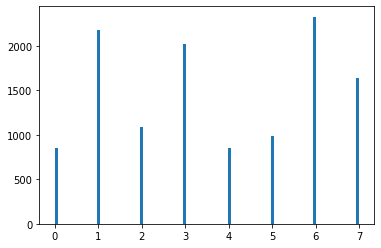

In [3]:

# print class imbalance
plt.hist(y_train, bins=100)
plt.show()


In [4]:
ALPHA = 0.1            # Regularization Parameter (Weights the Reg. Term)
EPSILON = 0.02        # Input Peturbation Budget at Training Time
GAMMA = 0.02           # Model Peturbation Budget at Training Time 
                        #(Changed to proportional budget rather than absolute)
    
LEARN_RATE = 0.0025      # Learning Rate Hyperparameter
HIDDEN_DIM = 100       # Hidden Neurons Hyperparameter
HIDDEN_LAY = 1         # Hidden Layers Hyperparameter
MAX_EPOCHS = 75

EPSILON_LINEAR = True   # Put Epsilon on a Linear Schedule?
GAMMA_LINEAR = True     # Put Gamma on a Linear Schedule?

In [5]:
#dm = medmnist_dm(batch_size=100, num_workers=0)

if(ALPHA != 0):
    mode = "GRAD"
else:
    mode = "NONE"
if(dataset in ["pathmnist", "bloodmnist", "retinamnist"]):
    model = XAIArchitectures.DeepMindSmall(dataset='MEDMNIST', mode = mode) 
elif(dataset == "tissuemnist"):
    model = XAIArchitectures.DeepMindSmall(dataset='TISSUEMNIST', mode=mode)
elif(dataset == "dermamnist"):
    model = XAIArchitectures.DeepMindSmall(dataset='DERMAMNIST', mode=mode)
else:
    model = XAIArchitectures.FullyConnected(dataset='PNEUMONIAMNIST', mode=mode) 
    #model = XAIArchitectures.(dataset='PNEUMONIAMNIST', mode="GRAD") 

model.set_params(alpha=ALPHA, epsilon=EPSILON, gamma=GAMMA,
                learn_rate=LEARN_RATE, max_epochs=MAX_EPOCHS,
                epsilon_linear=EPSILON_LINEAR,gamma_linear=GAMMA_LINEAR)


In [6]:

trainer = pl.Trainer(max_epochs=MAX_EPOCHS, accelerator="cpu", devices=1)
trainer.fit(model, datamodule=dm)
result = trainer.test(model, datamodule=dm)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 784   
1 | conv2 | Conv2d | 8.2 K 
2 | fc1   | Linear | 320 K 
3 | fc2   | Linear | 1.0 K 
---------------------------------
330 K     Trainable params
0         Non-trainable params
330 K     Total params
1.320     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/matthewwicker/opt/anaconda3/envs/XAIenvironment/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Users/matthewwicker/opt/anaconda3/envs/XAIenvironment/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking func

Training: 0it [00:00, ?it/s]

../GradCertModule.py:282: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2318.)
  return dL_min.T, dL_max.T #dL_dz_min.T, dL_dz_max.T


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/matthewwicker/opt/anaconda3/envs/XAIenvironment/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6781904697418213
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [7]:
# Finally, we save the model IDed by its relevant parameters
import os

directory = "Models"
if not os.path.exists(directory):
    os.makedirs(directory)
    
SCHEDULED = EPSILON_LINEAR or GAMMA_LINEAR
    
MODEL_ID = "DeepMindSmall_%s_e=%s_g=%s_a=%s_s=%s"%(dataset, EPSILON, GAMMA, ALPHA, SCHEDULED)
print(MODEL_ID)
trainer.save_checkpoint("Models/%s.ckpt"%(MODEL_ID))

torch.save(model.state_dict(), "Models/%s.pt"%(MODEL_ID))

#DeepMindSmall_pneumoniamnist_e=0.1_g=0.0_a=1.0_s=True


DeepMindSmall_bloodmnist_e=0.02_g=0.02_a=0.1_s=True
